In [1]:
import pandas as pd
import numpy as np
from sklearn import *
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score

In [2]:
data = pd.read_pickle('./ass2.pickle')
train, dev, test = data['train'], data['dev'], data['test'] 
print(f"number of features: {len(train.columns) - 1}")
print(f"types of labels: {train['target'].unique()}")

print(f"number of rows in train: {len(train)}")
print(f"number of rows in dev: {len(dev)}")
print(f"number of rows in test: {len(test)}")


number of features: 42
types of labels: [2 1 0]
number of rows in train: 40533
number of rows in dev: 13512
number of rows in test: 13512


<Axes: xlabel='target'>

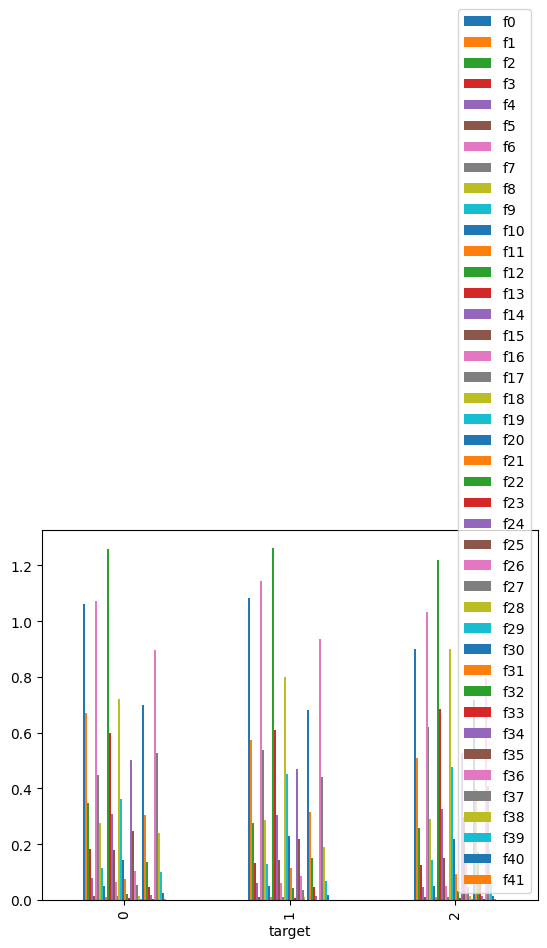

In [3]:
train.groupby('target').mean().plot(kind='bar')

In [4]:
train_features, train_labels = train.drop('target', axis=1), train['target']
rf = RandomForestClassifier()
rf.fit(train_features, train_labels)
y_pred = rf.predict(dev.drop('target', axis=1))
accuracy = accuracy_score(dev['target'], y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8119449378330373


In [5]:
clf = GradientBoostingClassifier(n_estimators=100, random_state=0).fit(train_features, train_labels)
y_pred = clf.predict(dev.drop('target', axis=1))
accuracy = accuracy_score(dev['target'], y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7551805802249852


In [6]:
xgb_model = xgb.XGBClassifier(objective="multi:softprob", random_state=42)
xgb_model.fit(train_features, train_labels)
y_pred = xgb_model.predict(dev.drop('target', axis=1))
accuracy = accuracy_score(dev['target'], y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8335553582001184
